# Model Payment Failures at TrueLayer

## 1. Setting up the environment, importing libraries and loading the data

In [1]:
import tpot
from helper import get_env_variable


import pandas as pd
import logging
from dotenv import load_dotenv
import os
import numpy as np

# load the .env file in the directory
load_dotenv()

# import data path from .env file 
path = os.environ['DATA_PATH']

# Configure logging
logging.basicConfig(level=logging.INFO)

try:
    truelayer_data = pd.read_csv(path)
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("The specified CSV file was not found.")
except Exception as e:
    logging.error(f"An error occurred: {e}")



INFO:root:Data loaded successfully.


In [2]:
truelayer_data.head()

,id,bank_id,currency,status,api_version,failure_reason,failure_stage,customer_id,vertical,connectivity_type,amount_in_currency,country_id,createdat_ts,lastupdatedat_ts,initiated_at,executed_at,failed_at,authorizing_at,authorized_at,settled_at
0,3c6646ef17a52ac2e35fdb6a15aa44db6d85985b,b5ab8f51d35b64af079485e5bbbc335213f3a0ae,CAD,Executed,v3,NaN,NaN,365a3d703f257f52adde00af51c7f4897a6f9c6a,vertical 2,type 8,28.0,9e2b06736b477b7a924f60de14a7e329d82d6f4f,2010-02-10 06:00:06.452249,2010-02-10 06:00:14.766862,2010-02-10 06:00:06.452249,2010-02-10 06:00:14.766862,NaN,2010-02-10 06:00:06.452249,2010-02-10 06:00:06.452249,NaN
1,6c3e58befae5a4880c62c54bdffe7243ab7b66cc,34a0061ba48d1c2810cd930dd69d42482ca92d85,CAD,Executed,v3,NaN,NaN,365a3d703f257f52adde00af51c7f4897a6f9c6a,vertical 2,type 8,18.0,9e2b06736b477b7a924f60de14a7e329d82d6f4f,2010-01-12 06:00:17.890703,2010-01-12 06:00:22.517782,2010-01-12 06:00:17.890703,2010-01-12 06:00:22.517782,NaN,2010-01-12 06:00:17.890703,2010-01-12 06:00:17.890703,NaN
2,b2ee452081f287aa12f0efbd05c278edd332def9,660054a4565377c6e43ff7709abf56d8494ba604,CAD,Executed,v3,NaN,NaN,365a3d703f257f52adde00af51c7f4897a6f9c6a,vertical 2,type 8,28.5,9e2b06736b477b7a924f60de14a7e329d82d6f4f,2010-02-10 07:20:57.816799,2010-02-10 07:21:04.284348,2010-02-10 07:20:57.816799,2010-02-10 07:21:04.284348,NaN,2010-02-10 07:20:57.816799,2010-02-10 07:20:57.816799,NaN
3,5aa68c655e0ca1e57bcf4a70c269151811e3ee77,660054a4565377c6e43ff7709abf56d8494ba604,CAD,Executed,v3,NaN,NaN,365a3d703f257f52adde00af51c7f4897a6f9c6a,vertical 2,type 8,16.0,9e2b06736b477b7a924f60de14a7e329d82d6f4f,2010-02-10 06:00:20.172570,2010-02-10 06:00:25.549863,2010-02-10 06:00:20.172570,2010-02-10 06:00:25.549863,NaN,2010-02-10 06:00:20.172570,2010-02-10 06:00:20.172570,NaN
4,1d72b60adefab1066d7421d72a2c3abb3d558544,0090e57640ed78b0c16ac4606a6773769545bb17,CAD,Executed,v3,NaN,NaN,64c370a753b1db282770cdbf2aba5434a3185b3d,vertical 2,type 8,5.0,9e2b06736b477b7a924f60de14a7e329d82d6f4f,2009-08-14 13:42:02.939891,2009-08-14 13:42:54.515245,2009-08-14 13:42:09.978416,2009-08-14 13:42:54.515245,NaN,2009-08-14 13:42:03.699860,2009-08-14 13:42:52.858713,2009-08-14 13:42:54.515245


In [3]:
truelayer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  500000 non-null  object 
 1   bank_id             500000 non-null  object 
 2   currency            500000 non-null  object 
 3   status              500000 non-null  object 
 4   api_version         500000 non-null  object 
 5   failure_reason      44628 non-null   object 
 6   failure_stage       44628 non-null   object 
 7   customer_id         500000 non-null  object 
 8   vertical            499988 non-null  object 
 9   connectivity_type   483695 non-null  object 
 10  amount_in_currency  500000 non-null  float64
 11  country_id          500000 non-null  object 
 12  createdat_ts        500000 non-null  object 
 13  lastupdatedat_ts    500000 non-null  object 
 14  initiated_at        237284 non-null  object 
 15  executed_at         377876 non-nul

In [4]:
def create_time_features(dataframe):
    """
    Convert specified time columns in the dataframe to datetime format.
    """
    # time_columns = [col for col in dataframe.columns if col.endswith(('_ts', '_at'))]
    
    for time_col in ['initiated_at', 'failed_at']:
        if time_col in dataframe.columns:
            dataframe[time_col] = pd.to_datetime(dataframe[time_col])


# Call the function with the truelayer_data
create_time_features(truelayer_data)


## 2. Exploratory Data Analysis

In [5]:
def calc_failed_transac_per():
    count_failed= len(truelayer_data[truelayer_data['settled_at'].notna()]['id'].unique())
    count_total_transaction= len(truelayer_data['id'].unique())
    perc= (count_failed / count_total_transaction) * 100
    return f"{perc:.2f}% failed transactions"

calc_failed_transac_per()

'14.67% failed transactions'

In [6]:
# select all rows where there are failed transactions
failed_df = truelayer_data[truelayer_data['settled_at'].notna()]

# sum the total amount of failed transactions
failed_df.groupby('currency').agg({'amount_in_currency':'sum'}).reset_index()

,currency,amount_in_currency
0,CAD,949641.2
1,USD,44214.5


## 3. Feature Engineering

In [7]:
truelayer_data['time_diff'] = (truelayer_data['failed_at'] - truelayer_data['initiated_at']).dt.total_seconds() 

In [8]:
# fill nan values in connectivity_type with 'type 0'
truelayer_data['connectivity_type'] = truelayer_data['connectivity_type'].fillna('type 0')


truelayer_data['amount_in_currency'] = truelayer_data['amount_in_currency'] 

In [9]:
# apply lambda function to create target variable
truelayer_data['s_pay_yes_no'] = truelayer_data['settled_at'].apply(lambda x: 0 if pd.notna(x) else 1)

In [10]:
# apply lambda function to create target variable
# truelayer_data['s_pay_yes_no'] = truelayer_data['failed_at'].apply(lambda x: 0 if pd.notna(x) else 1)

# initialise feature set X
X= truelayer_data.loc[:,['country_id', 'connectivity_type', 'api_version','amount_in_currency','time_diff']].copy()

# intialise feature set y
y= truelayer_data['s_pay_yes_no'].values


In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoders = {}

# Label encode each categorical feature in X
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le  # Store the encoder for potential inverse transformation later


In [12]:
X['time_diff'].fillna(0, inplace=True)


/var/folders/bc/ch17snhx0lddzb35lcgwsn5r0000gn/T/ipykernel_22571/4208561580.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['time_diff'].fillna(0, inplace=True)


In [13]:
from sklearn.utils import resample

# Combine the features and target variable into a single DataFrame
data = X.copy()
data['s_pay_yes_no'] = y

# Separate majority and minority classes
majority = data[data['s_pay_yes_no'] == 0]
minority = data[data['s_pay_yes_no'] == 1]

# Ensure that we only undersample if the majority class is larger than the minority class
if len(majority) > len(minority):
    # Randomly undersample the majority class
    majority_undersampled = resample(majority, 
                                       replace=False,    # sample without replacement
                                       n_samples= 1.2 * len(minority),  # to match minority class
                                       random_state=42)  # reproducible results

    # Combine minority class with undersampled majority class
    undersampled_data = pd.concat([majority_undersampled, minority])
else:
    # If the majority class is not larger, use the original data without undersampling
    undersampled_data = data

# Separate features and target variable again
X_undersampled = undersampled_data.drop('s_pay_yes_no', axis=1)
y_undersampled = undersampled_data['s_pay_yes_no'].values

# Ensure that the data is shuffled after undersampling
X_undersampled, y_undersampled = resample(X_undersampled, y_undersampled, random_state=42)


In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, 
                                                    y_undersampled, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, shuffle=True)


## 4. Model Development (AutoML)


In [15]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(scoring='f1_weighted',
                      verbosity=3,
                      n_jobs=-1,
                      generations=10, 
                      population_size=100,
                      cv=3,
                      max_time_mins=10)

tpot.fit(X_train, y_train)
tpot.score(X_test, y_test)

32 operators have been imported by TPOT.
Skipped pipeline #41 due to time out. Continuing to the next pipeline.        
                                                                             
11.68 minutes have elapsed. TPOT will close down.                            
TPOT closed during evaluation in one generation.
                                                                             
                                                                             
TPOT closed prematurely. Will use the current best pipeline.


/Users/zaahirdawood/Documents/automl-truelayer/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


np.float64(0.8678459491776711)

## 5. Model Evaluation

In [16]:
print(tpot.fitted_pipeline_) 


Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=LinearSVC(C=25.0, dual=True,
                                                       loss='hinge',
                                                       tol=0.1))),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.5, min_samples_leaf=2,
                                        min_samples_split=10))])


In [17]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions on the test set
y_pred = tpot.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

# Calculate the AUC ROC score
y_prob = tpot.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC ROC Score: {auc_score:.4f}')


/Users/zaahirdawood/Documents/automl-truelayer/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.57      0.49      0.53     14682
           1       0.91      0.94      0.93     85318

    accuracy                           0.87    100000
   macro avg       0.74      0.72      0.73    100000
weighted avg       0.86      0.87      0.87    100000



/Users/zaahirdawood/Documents/automl-truelayer/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


AUC ROC Score: 0.9143


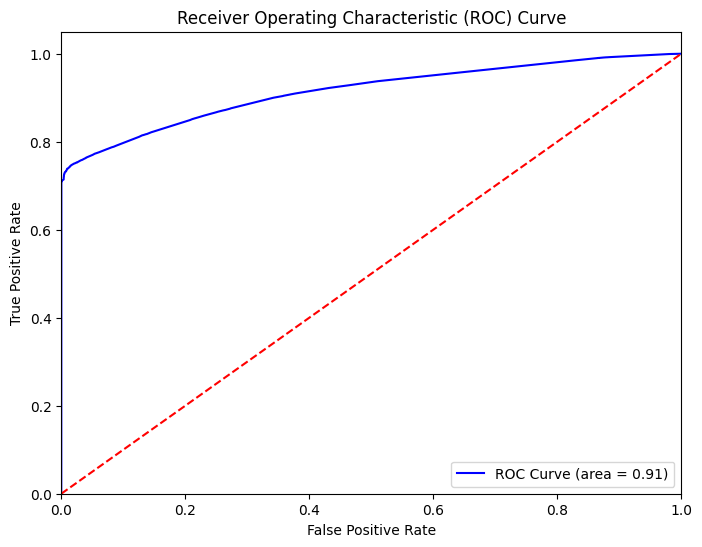

In [18]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [19]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_pred,y_test)

print(cm)

[[ 7256  5387]
 [ 7426 79931]]


## 6. Model Selection

In [20]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

def custom_transformation(X):
    # Replace this with your transformation logic
    return X

# Create transformers
scaler = StandardScaler()
custom_transformer = FunctionTransformer(func=custom_transformation)

# Construct the pipeline
pipeline = Pipeline(steps=[
    ('featureunion', FeatureUnion(transformer_list=[
        ('scaler', scaler),
        ('custom_transformer', custom_transformer)
    ])),
    ('extratreesclassifier', ExtraTreesClassifier(class_weight='balanced',criterion='entropy', max_features=0.1, min_samples_split=12)) #add balanced class
])

# Fit the pipeline on training data (X_train, y_train)
pipeline.fit(X_undersampled, y_undersampled)

# Make predictions
y_pred = pipeline.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_pred,y_test)

print(cm)

[[14545 21141]
 [  137 64177]]


In [22]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Generate the classification report
print(classification_report(y_test, y_pred))

# Calculate the AUC ROC score
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC ROC Score: {auc_score:.4f}')


              precision    recall  f1-score   support

           0       0.41      0.99      0.58     14682
           1       1.00      0.75      0.86     85318

    accuracy                           0.79    100000
   macro avg       0.70      0.87      0.72    100000
weighted avg       0.91      0.79      0.82    100000

AUC ROC Score: 0.9199


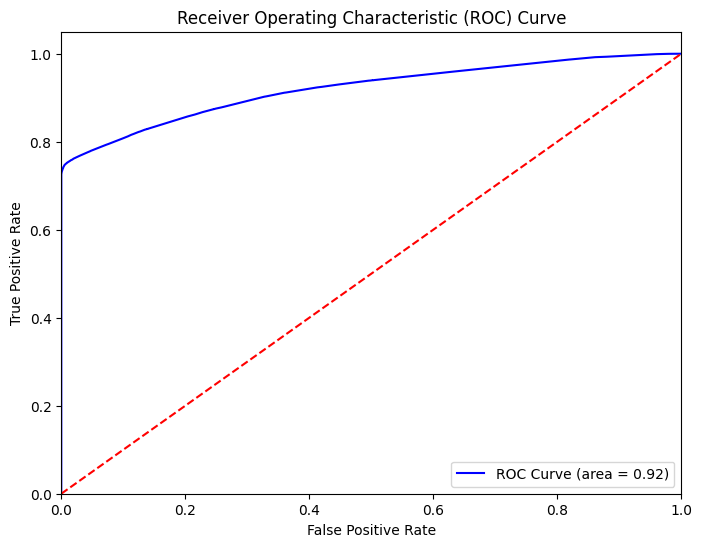

In [23]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 7. Save model & pipeline

In [32]:
import joblib

tpot.export('models/tpot_pipeline.py')
# Assuming 'pipeline' is your trained pipeline object
joblib.dump(pipeline, 'models/winner.pkl')

['models/winner.pkl']

In [25]:
prob_val = pipeline.predict_proba(X_test)[:, 0]
final_df = pd.DataFrame({'Probability_Failed': prob_val, 'Actual_Result': y_test})

final_df.to_csv('review.csv',index=False)

In [26]:
final_df.groupby('Actual_Result')['Probability_Failed'].describe()

,count,mean,std,min,25%,50%,75%,max
Actual_Result,,,,,,,,
0,14682.0,0.807287,0.110820,0.074415,0.740592,0.863236,0.873152,1.000000
1,85318.0,0.191357,0.324084,0.000000,0.000000,0.000000,0.474797,0.984837


## 8. CI/CD output

In [28]:
from sklearn.metrics import make_scorer, f1_score

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

final_model_score = f1_score(y_test, pipeline.predict(X_test), average='weighted')


In [29]:
!touch results.txt
!echo f"weighted_f1_score: {final_model_score}" >> results.txt

## 9. Conclusion - Forseeable Improvements

Summary:

- Improved Class 0 (Failed Payments) Recall: The weighted model does a much better job of identifying almost all failed payments, which could be critical depending on your business requirements.
-	Trade-Off for Class 1 (Successful Payments): There’s a notable drop in recall for successful payments, meaning the model is more likely to incorrectly predict failures when a payment actually succeeds.

Which Version is Better?

-	The priority is to detect as many failed payments as possible (high recall for class 0), the weighted version is better.
-	If misclassifying successful payments is more costly (lower recall for class 1 is undesirable), you might want to further tune the model or use a middle-ground approach (e.g., adjusting weights further, trying other models, or resampling the data).

The weighted model performs well based on the high AUC ROC score.


Improvements:

 - 1. **Feature Scaling**: If not already done, consider applying feature scaling techniques such as Min-Max Scaling or Standardization to ensure that all features contribute equally to the model's performance.

- 2. **Feature Engineering**: Explore creating new features that could provide additional insights, such as:
    - Time-based features (e.g., day of the week, month, or hour of the transaction).
    - Aggregated features (e.g., rolling averages of transaction amounts).
 
- 3. **Handling Imbalanced Data**: If the dataset is imbalanced, consider techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN to generate synthetic samples for the minority class.

